# Классификация изображений
### Основная идея этого решения: взять предобученую сеть и дообучить под нашу задачу
По отзывам была выбрана есть EfficientB6, дающая высокую точность при приемлимом количестве параметров
B7 на пробном тестировании не показала существенного улучшения, но требовала больше времени на обучение, 
что затрудняло дальнейшие экспиременты.



# Преднастройки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.io
import tarfile
import csv
import sys
import os

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
import efficientnet.tfkeras as efn

#from ImageDataAugmentor.image_data_augmentor import *
#import albumentations

from sklearn.model_selection import train_test_split

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir(os.getcwd() + "/input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', keras.__version__)

INFO:tensorflow:Using local port 17983
INFO:tensorflow:Using local port 15741
INFO:tensorflow:Using local port 15821
INFO:tensorflow:Using local port 18792
INFO:tensorflow:Using local port 16742
INFO:tensorflow:Using local port 23505
INFO:tensorflow:Using local port 17188
INFO:tensorflow:Using local port 21987
INFO:tensorflow:Using local port 17244
INFO:tensorflow:Using local port 21213
['model_last.hdf5', 'train.csv', 'sample-submission.csv', 'test_upload', 'train']
Python       : 3.8.5 (default, Jul 28 2020, 12:59:40) 
Numpy        : 1.18.5
Tensorflow   : 2.4.0
Keras        : 2.4.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


# Основные настройки

In [3]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Batch size
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
BATCH_SIZE_STEP4     = 2 # Размер batch на шаге с увеличенными изображениями

# Epochs

EPOCHS_STEP1         = 30 
EPOCHS_STEP2         = 30 
EPOCHS_STEP3         = 30
EPOCHS_STEP4         = 30 

# Learning Rates
LR_STEP1             = 1e-3
LR_STEP2             = 1e-4
LR_STEP3             = 1e-5
LR_STEP4             = 1e-5
EPOCHS               = 30  # эпох на обучение
LR                   = 1e-3
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 250 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [4]:
DATA_PATH = '/home/alex/Car_Classification/input/'
sample_submission = pd.read_csv(DATA_PATH + "sample-submission.csv")
MODEL_PATH = '/home/alex/Car_Classification/model/'

In [5]:
# Устаналиваем конкретное значение random seed для воспроизводимости

RANDOM_SEED = 1488
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [6]:
df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [8]:
df.Category.value_counts()
# распределение классов достаточно равномерное - датасет сбалансирован

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

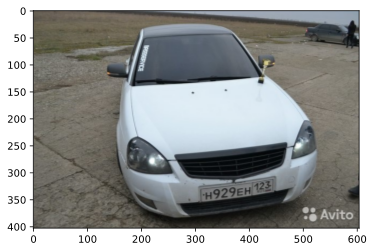

(604, 403)

In [13]:
image = PIL.Image.open(DATA_PATH+'/train/0/18293.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size



Как мы видим, классы указывают на модели автомобилей ВАЗ, также присутствуют Ford Focus и Volkswagen Passat


# Подготовка данных

## Аугментация данных

In [7]:
# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)

train_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range = 30,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    brightness_range=[0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

## Генерация данных

In [8]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    DATA_PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    DATA_PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


Пример картинок из train_generator


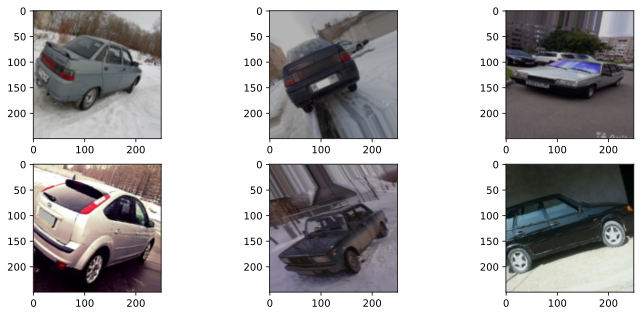

In [19]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

Пример картинок из test_generator


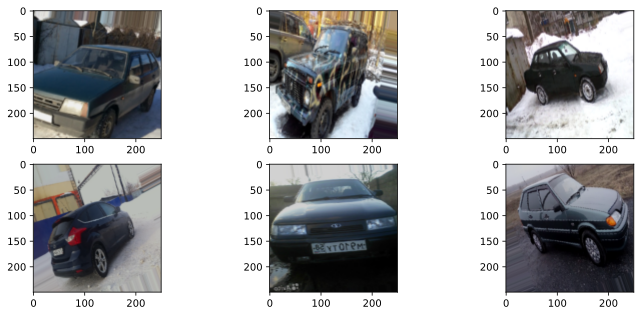

In [18]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Построение модели

За основу берем сеть EfficientB6 в реализации https://github.com/qubvel/efficientnet
Из модуля tf.keras.application с настройками по умолчанию дает точность 11% на первых шагах обучения
против 50% в применяемой реализации.


In [20]:
base_model = efn.EfficientNetB6(
    weights='imagenet',  # возможен вариант noisy-student
    include_top=False,   # голову мы заменяем по причине других классов в исходной сети и главное их количества
    input_shape=input_shape
    )

In [21]:
base_model.summary()

________________
block6h_project_bn (BatchNormal (None, 8, 8, 344)    1376        block6h_project_conv[0][0]       
__________________________________________________________________________________________________
block6h_drop (FixedDropout)     (None, 8, 8, 344)    0           block6h_project_bn[0][0]         
__________________________________________________________________________________________________
block6h_add (Add)               (None, 8, 8, 344)    0           block6h_drop[0][0]               
                                                                 block6g_add[0][0]                
__________________________________________________________________________________________________
block6i_expand_conv (Conv2D)    (None, 8, 8, 2064)   710016      block6h_add[0][0]                
__________________________________________________________________________________________________
block6i_expand_bn (BatchNormali (None, 8, 8, 2064)   8256        block6i_expand_conv[0][0]  

In [22]:
# Заморозим веса imagenet в базовой модели, чтобы она работала в качестве feature extractor 
# и наша голова обучалась делать классификацию на наши 10 классов

base_model.trainable = False

#### Устанавливаем кастомную "голову" в минималистическо классической конфигурации

In [23]:
# Устанавливаем "голову" в минималистическо классической конфигурации
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))

model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [24]:
# Смотрим на получившуюся модель
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 8, 8, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 593,162
Non-trainable params: 40,960,648
______________________________________

In [25]:
# Количество слоев
print(len(model.layers))

6


In [26]:
# Количество параметров обучения
len(model.trainable_variables)

6

In [27]:
# Статус слоев - будем обучать или нет
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7fbf527a3cd0> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fbf9a5d3af0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fbe4cd42a00> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fbe602b3be0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7fbe60211700> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fbe60217ca0> True


# Обучение модели

## Step 1 - обучение "головы"

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [28]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [29]:
checkpoint = ModelCheckpoint(MODEL_PATH+'step1-{epoch:02d}-{val_loss:.4f}.hdf5' , monitor = ['val_accuracy'] , verbose = 1, mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [30]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 35s 79ms/step - loss: 2.3205 - accuracy: 0.0870
Accuracy: 9.42%


In [31]:
# Обучаем
history = model.fit(
                    train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=test_generator, 
                    validation_steps=test_generator.samples//test_generator.batch_size,
                    epochs=EPOCHS_STEP1,
                    callbacks = callbacks_list
                    )

Epoch 1/30
1556/1556 [==============================] - 161s 99ms/step - loss: 1.6800 - accuracy: 0.4103 - val_loss: 1.1170 - val_accuracy: 0.5905

Epoch 00001: saving model to /home/alex/Car_Classification/model/step1-01-1.1170.hdf5
Epoch 2/30
1556/1556 [==============================] - 153s 98ms/step - loss: 1.4395 - accuracy: 0.4867 - val_loss: 1.1020 - val_accuracy: 0.5947

Epoch 00002: saving model to /home/alex/Car_Classification/model/step1-02-1.1020.hdf5
Epoch 3/30
1556/1556 [==============================] - 151s 97ms/step - loss: 1.3573 - accuracy: 0.5153 - val_loss: 0.9903 - val_accuracy: 0.6472

Epoch 00003: saving model to /home/alex/Car_Classification/model/step1-03-0.9903.hdf5
Epoch 4/30
1556/1556 [==============================] - 151s 97ms/step - loss: 1.3073 - accuracy: 0.5351 - val_loss: 0.9341 - val_accuracy: 0.6749

Epoch 00004: saving model to /home/alex/Car_Classification/model/step1-04-0.9341.hdf5
Epoch 5/30
1556/1556 [==============================] - 151s 97m

удивительно на сколько эта модель хорошо умеет извлекать признаки!

даже без дообучения получаем столь высокий Accuracy



In [32]:
# Сохраняем обученную модель на первом шаге

model.save('model/model_step1.hdf5')

# Запрашиваем какой файл с весами загрузить как лучший на первом шаге обучения

while not os.path.isfile(weights_name := input('Input name of weights file: ')):
    print("File not exist!")

model.load_weights(weights_name)

In [21]:
def plot_step_learn(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

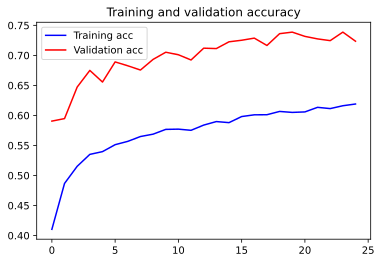

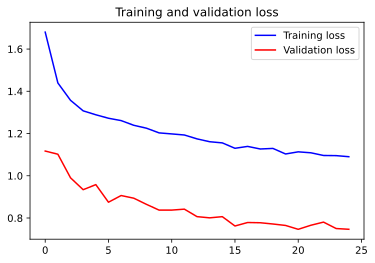

In [34]:
plot_step_learn(history)

## Step 2 - FineTuning. Разморозка половины слоев базовой модели для обучения

In [35]:
# Посмотрим на количество слоев в базовой модели
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  659


In [36]:
# Разморозим базовую модель
base_model.trainable = True

# Установим количество слоев, которые будем переобучать
fine_tune_at = len(base_model.layers)//2

# Заморозим первую половину слоев
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [37]:
# Количество параметров
len(base_model.trainable_variables)

291

In [38]:
# Статус слоев - будем обучать или нет
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7fbf527a3cd0> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fbf9a5d3af0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fbe4cd42a00> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fbe602b3be0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7fbe60211700> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fbe60217ca0> True


In [39]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR_STEP2), metrics=["accuracy"])
checkpoint2 = ModelCheckpoint(MODEL_PATH+'step2-{epoch:02d}-{val_loss:.4f}.hdf5' , monitor = ['val_accuracy'] , verbose = 1, mode = 'max')

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 8, 8, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 38,289,632
Non-trainable params: 3,264,178
____________________________________

In [41]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 33s 80ms/step - loss: 0.9106 - accuracy: 0.6856
Accuracy: 67.39%


In [42]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = EPOCHS_STEP2,
    callbacks = [checkpoint2, earlystop],
    verbose=2
)

Epoch 1/30
1556/1556 - 163s - loss: 1.0877 - accuracy: 0.6315 - val_loss: 0.3978 - val_accuracy: 0.8476

Epoch 00001: saving model to /home/alex/Car_Classification/model/step2-01-0.3978.hdf5
Epoch 2/30
1556/1556 - 153s - loss: 0.6026 - accuracy: 0.7880 - val_loss: 0.2743 - val_accuracy: 0.9014

Epoch 00002: saving model to /home/alex/Car_Classification/model/step2-02-0.2743.hdf5
Epoch 3/30
1556/1556 - 152s - loss: 0.4537 - accuracy: 0.8396 - val_loss: 0.2184 - val_accuracy: 0.9185

Epoch 00003: saving model to /home/alex/Car_Classification/model/step2-03-0.2184.hdf5
Epoch 4/30
1556/1556 - 154s - loss: 0.3755 - accuracy: 0.8734 - val_loss: 0.2069 - val_accuracy: 0.9211

Epoch 00004: saving model to /home/alex/Car_Classification/model/step2-04-0.2069.hdf5
Epoch 5/30
1556/1556 - 156s - loss: 0.3114 - accuracy: 0.8942 - val_loss: 0.1926 - val_accuracy: 0.9343

Epoch 00005: saving model to /home/alex/Car_Classification/model/step2-05-0.1926.hdf5
Epoch 6/30
1556/1556 - 155s - loss: 0.2718 - 

In [43]:
model.save('model/model_step2.hdf5')

while not os.path.isfile(weights_name := input('Input name of weights file: ')):
    print("File not exist!")
model.load_weights(weights_name)

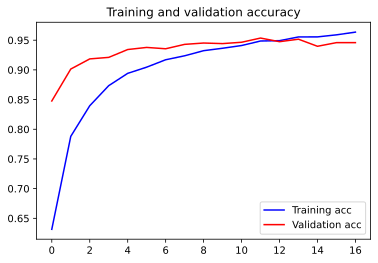

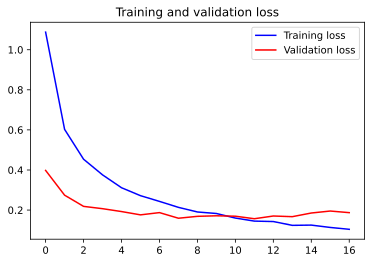

In [44]:
plot_step_learn(history)

In [45]:
scores = model.evaluate(test_generator, verbose=2)
print("Accuracy step2: %.2f%%" % (scores[1]*100))

389/389 - 31s - loss: 0.1869 - accuracy: 0.9447
Accuracy step2: 94.47%


## Step 3 - FineTuning - разморозка всей сети EfficientNetB6 и дообучение

In [46]:
# Разморозим базовую модель
base_model.trainable = True

Повторно обучим модель, предварительно разморозив все слои

In [47]:
LR=0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR_STEP3), metrics=["accuracy"])
checkpoint3 = ModelCheckpoint(MODEL_PATH+'step3-{epoch:02d}-{val_loss:.4f}.hdf5' , monitor = ['val_accuracy'] , verbose = 1, mode = 'max')
callbacks_list = [checkpoint3, earlystop]

In [48]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 20,
        callbacks = callbacks_list
)

Epoch 1/20
1556/1556 [==============================] - 255s 157ms/step - loss: 0.1013 - accuracy: 0.9650 - val_loss: 0.1590 - val_accuracy: 0.9526

Epoch 00001: saving model to /home/alex/Car_Classification/model/step3-01-0.1590.hdf5
Epoch 2/20
1556/1556 [==============================] - 237s 153ms/step - loss: 0.0935 - accuracy: 0.9661 - val_loss: 0.1386 - val_accuracy: 0.9594

Epoch 00002: saving model to /home/alex/Car_Classification/model/step3-02-0.1386.hdf5
Epoch 3/20
1556/1556 [==============================] - 236s 152ms/step - loss: 0.0802 - accuracy: 0.9720 - val_loss: 0.1509 - val_accuracy: 0.9597

Epoch 00003: saving model to /home/alex/Car_Classification/model/step3-03-0.1509.hdf5
Epoch 4/20
1556/1556 [==============================] - 246s 158ms/step - loss: 0.0769 - accuracy: 0.9727 - val_loss: 0.1448 - val_accuracy: 0.9591

Epoch 00004: saving model to /home/alex/Car_Classification/model/step3-04-0.1448.hdf5
Epoch 5/20
1556/1556 [==============================] - 237s

In [49]:
model.save('model/model_step3.hdf5')

while not os.path.isfile(weights_name := input('Input name of weights file: ')):
    print("File not exist!")
model.load_weights(weights_name)

In [50]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 31s 79ms/step - loss: 0.1477 - accuracy: 0.9608
Accuracy: 96.08%


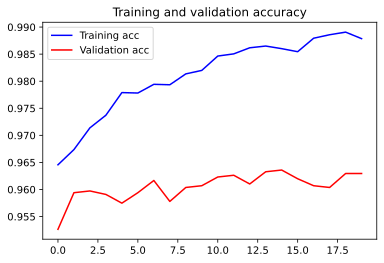

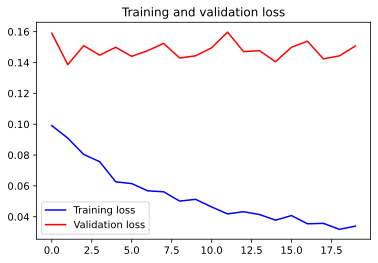

In [51]:
plot_step_learn(history)

## Step 4 - увеличение размера изображения

In [10]:
EPOCHS               = 20
BATCH_SIZE           = 3 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-5

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range = 30,
    #shear_range=0.2,
    zoom_range=[0.75,1.25],
    #brightness_range=[0.5, 1.5],
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    validation_split=VAL_SPLIT,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [15]:
train_generator = train_datagen.flow_from_directory(
    DATA_PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE_STEP4,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    DATA_PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE_STEP4,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


Заново создаем сеть с новым размером входных данных

In [9]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

In [10]:
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),) 
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [11]:
while not os.path.isfile(model_name := input('Input name of model file: ')):
    print(model_name, "File not exist!")
model = keras.models.load_model(model_name)

In [12]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR_STEP4), metrics=["accuracy"])

In [16]:
checkpoint = ModelCheckpoint(MODEL_PATH+'step4-{epoch:02d}-{val_loss:.4f}.hdf5' , monitor = ['val_accuracy'] , verbose = 1, mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [17]:
# Обучаем
history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS_STEP4,
        callbacks = callbacks_list
)

Epoch 1/30
6226/6226 [==============================] - 359s 56ms/step - loss: 0.7670 - accuracy: 0.8672 - val_loss: 0.1842 - val_accuracy: 0.9562

Epoch 00001: saving model to /home/alex/Car_Classification/model/step4-01-0.1842.hdf5
Epoch 2/30
6226/6226 [==============================] - 344s 55ms/step - loss: 0.6094 - accuracy: 0.8736 - val_loss: 0.2277 - val_accuracy: 0.9546

Epoch 00002: saving model to /home/alex/Car_Classification/model/step4-02-0.2277.hdf5
Epoch 3/30
6226/6226 [==============================] - 322s 52ms/step - loss: 0.5834 - accuracy: 0.8802 - val_loss: 0.1879 - val_accuracy: 0.9627

Epoch 00003: saving model to /home/alex/Car_Classification/model/step4-03-0.1879.hdf5
Epoch 4/30
6226/6226 [==============================] - 323s 52ms/step - loss: 0.5681 - accuracy: 0.8805 - val_loss: 0.2008 - val_accuracy: 0.9585

Epoch 00004: saving model to /home/alex/Car_Classification/model/step4-04-0.2008.hdf5
Epoch 5/30
6226/6226 [==============================] - 323s 52m

In [18]:
model.save('model/model_step4.hdf5')

while not os.path.isfile(weights_name := input('Input name of weights file: ')):
    print("File not exist!")
model.load_weights(weights_name)

In [19]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1555/1555 [==============================] - 29s 18ms/step - loss: 0.2135 - accuracy: 0.9579
Accuracy: 95.79%


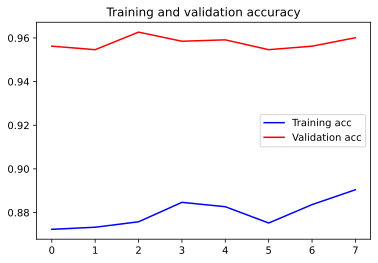

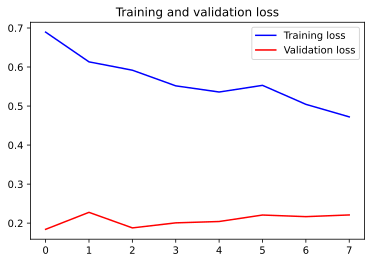

In [22]:
plot_step_learn(history)

# Предсказание на тестовых данных

In [23]:
from sklearn.metrics import accuracy_score

In [25]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=DATA_PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 6675 validated image filenames.


In [26]:
test_sub_generator.samples

6675

In [27]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

835/835 [==============================] - 28s 32ms/step


In [28]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [ ]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,9


# Test Time Augmentation

https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

Аугментируем тестовые изображения и сделаем несколько предсказаний одной картинки в разном виде. Взяв среднее значение из нескольких предсказаний получим итоговое предсказание.

In [30]:
while not os.path.isfile(weights_name := input('Input name of weights file: ')):
    print("File not exist!")
model.load_weights(weights_name)

In [31]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range = 30,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    brightness_range=[0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
  )

In [33]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=DATA_PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [34]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

835/835 [==============================] - 65s 77ms/step


In [35]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [36]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA.csv', index=False)
print('Save submit')

Save submit


# Итоги и выводы